### Compare loss, convergence and forecast accuracy of the MLPs
across the dimension of the avtivation function, and the optimizer

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
result_filename = "MLP_competition_results.txt"
result_file = open(result_filename,'r')
results_datastring = result_file.read()
result_file.close()

read_output_text = results_datastring

In [3]:
print("text len: ",len(read_output_text))

rezsplit_a = read_output_text.split("\n")
print("split text len: ",len(rezsplit_a))
# Last line is just an empty new line. We remove it
print("last item in the split: ",rezsplit_a[-1].__repr__())
rezsplit_a.remove('')
print("split text len: ",len(rezsplit_a))
print('\n')

result_dict_list = [eval(rez) for rez in rezsplit_a]
print("dict len: ", len(result_dict_list))
print("dictionary keys: ",result_dict_list[0].keys())
print("1st item config: ",result_dict_list[0]["config"])
print("1st item min loss: ",min(result_dict_list[0]["result"]["loss"]))
print("1st item last loss: ",result_dict_list[0]["result"]["loss"][-1])

text len:  184950
split text len:  5
last item in the split:  ''
split text len:  4


dict len:  4
dictionary keys:  dict_keys(['epochs', 'config', 'result'])
1st item config:  {'layers': 3, 'layer': {1: 64, 2: 64, 3: 64}}
1st item min loss:  0.00013130514316469057
1st item last loss:  0.00015391332836281476


- Technically, we don't know the order of the trained MLP's

This would mean we don't know which used ReLU, Sigmoid, etc. This is because this data was not save intot the model info we were generating. However, we have saved the full Kera smodel config to a json file.  
We can now read form the file for each model and find out what type it was
- i.e. which activation and which optimizer

#### Keras Model Config files

In [4]:
modelconfigfilenames = ["MLP_competition_results_01_jsconfig.json",
                        "MLP_competition_results_02_jsconfig.json",
                        "MLP_competition_results_03_jsconfig.json",
                        "MLP_competition_results_04_jsconfig.json"]

def multiload(flist):
    outp = {}
    for f in flist:
        a = open(f,'r')
        b = a.read()
        a.close()
        outp[f] = b
    return outp

mcf_stringdata = multiload(modelconfigfilenames)

In [5]:
mcf_stringdata["MLP_competition_results_01_jsconfig.json"][:100]

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "Dense", "co'

In [6]:
for x in mcf_stringdata.items(): print(type(x),len(x))

<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2


In [7]:
def str_to_json_of_results():
    for a in mcf_stringdata:
        replace_true = mcf_stringdata[a].replace("true","True")
        replace_null = replace_true.replace("null","None")
        evaled = eval(replace_null)
        mcf_stringdata[a] = evaled

In [10]:
len(mcf_stringdata)

4

### Unfortunately, the Keras config doesn't include the optimizer
We'll have to refer to the Python script for the traiing order

In [11]:
# From the Pythons script
# we only need one configuration
cross_config = []
flat_config_1000_3_64 = [1000,3,64]
cross_config.append(flat_config_1000_3_64)
# activations
activs_list = ["relu","sigmoid"]
# optimizers
optims_list = ["adam","sgd"]
# combined to make other model settings
ao_settings = [[act,opt] for act in activs_list for opt in optims_list]

# combine settings with configs
full_spec = [(cnfig,setng)
             for cnfig in cross_config
             for setng in ao_settings]

In [12]:
full_spec

[([1000, 3, 64], ['relu', 'adam']),
 ([1000, 3, 64], ['relu', 'sgd']),
 ([1000, 3, 64], ['sigmoid', 'adam']),
 ([1000, 3, 64], ['sigmoid', 'sgd'])]

### So
- Model 01: relu adam
- Model 02: relu sgd
- Model 03: sigmoid adam
- Model 04: sigmoid sgd

### We move on to find MSE loss information

In [22]:
def one_res_repr_v2(rez_dict):
    j = ["config","epochs"]
    d = {}
    for jj in j: d[jj] = rez_dict[jj]
    d["result"] = {"last_loss":rez_dict["result"]["loss"][-1],
                   "min_loss":min(rez_dict["result"]["loss"])}
    return d

In [23]:
one_res_repr_v2(result_dict_list[0])

{'config': {'layer': {1: 64, 2: 64, 3: 64}, 'layers': 3},
 'epochs': 1000,
 'result': {'last_loss': 0.00015391332836281476,
  'min_loss': 0.00013130514316469057}}

In [24]:
MSE_loss_results = [{"epochs": item['epochs'],
                    "config":item["config"],
                    "last_loss": item["result"]["loss"][-1]} for item in result_dict_list]
print(MSE_loss_results[0])

{'epochs': 1000, 'config': {'layers': 3, 'layer': {1: 64, 2: 64, 3: 64}}, 'last_loss': 0.00015391332836281476}


In [25]:
ALL_last_loss = tuple(d["last_loss"] for d in MSE_loss_results)
print(len(ALL_last_loss))
print(min(ALL_last_loss))
ALL_last_loss[:5]

4
0.00015391332836281476


(0.00015391332836281476,
 0.0002592734960518722,
 0.00020681091811140635,
 0.0007770861919336144)

Based on the order of results here, model 1 was the winner

### ReLU Adam @ 0.00015391332836281476

#### 2nd Sigmoid Adam @ 0.00020681091811140635

#### 3rd ReLU SGD @ 0.0002592734960518722

#### 4th Sigmoid SGD @ 0.0007770861919336144

In [26]:
model01_lossprogression = result_dict_list[0]["result"]["loss"]
model02_lossprogression = result_dict_list[1]["result"]["loss"]
model03_lossprogression = result_dict_list[2]["result"]["loss"]
model04_lossprogression = result_dict_list[3]["result"]["loss"]

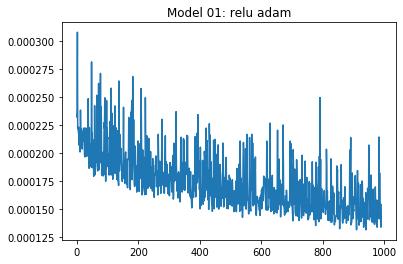

In [27]:
plt.plot(model01_lossprogression[9:])
plt.title("Model 01: relu adam")
plt.show()

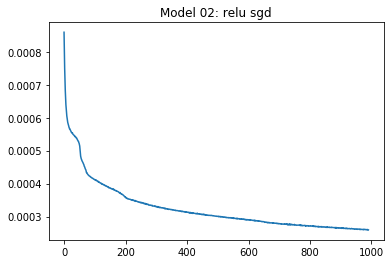

In [28]:
plt.plot(model02_lossprogression[9:])
plt.title("Model 02: relu sgd")
plt.show()

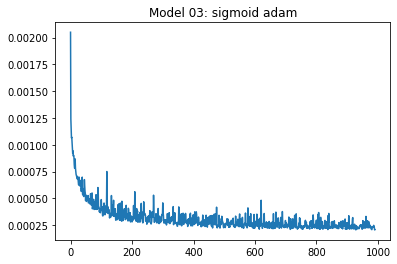

In [29]:
plt.plot(model03_lossprogression[9:])
plt.title("Model 03: sigmoid adam")
plt.show()

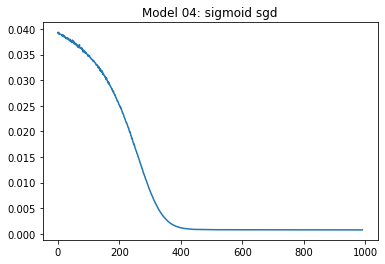

In [30]:
plt.plot(model04_lossprogression[9:])
plt.title("Model 04: sigmoid sgd")
plt.show()

Very different Loss metric convergence in the first 10 epochs  
Magnitude of y-axis emphasizes how much more optimal the winner was.

## Now let's try to get a forecast, and see how accurate it is

we need to import model config and weights, and rebuild the trained model

In [31]:
modelconfigfilenames = ("MLP_competition_results_01_jsconfig.json",
                        "MLP_competition_results_02_jsconfig.json",
                        "MLP_competition_results_03_jsconfig.json",
                        "MLP_competition_results_04_jsconfig.json")
modelweightfilenames = ("MLP_competition_results_01_weights.h5",
                        "MLP_competition_results_02_weights.h5",
                        "MLP_competition_results_03_weights.h5",
                        "MLP_competition_results_04_weights.h5")

- From the usual imports, we'll need the validation data, and Kera modules

In [33]:
import pandas as pd
import os
import numpy as np
import datetime

# other imports
import inspect
import sys
import time

# the file
snpnormfile = "../Reuters Data Copy/SandP500/snp_normalized_lagged.csv"
snp_a_data = pd.read_csv(snpnormfile,parse_dates=['Local_Datetime'],
                         index_col=0)

# just to keep from changing to many variable names below
snp_data_chrono = snp_a_data

# define MLP dataset
# we need to leave a validation set, which we can use for test later
y = snp_data_chrono['Close']
y_train = y.iloc[:1347-135]
y_validation = y.iloc[1347-135:]
X_train = snp_data_chrono.iloc[:1347-135,2:]
X_validation = snp_data_chrono.iloc[1347-135:,2:]

# for NN first imports
# for tensorflow with keras
import tensorflow
# due to a problem on Windows, force the aliasing
sys.modules['keras'] = tensorflow.keras

# for NN second imports
from keras.models import Sequential
from keras.layers import Dense

- We can now reload the save model(s) via configurations and weights

In [34]:
from keras.models import model_from_json

In [35]:
def get_model_config(mdlfn):
    stored_model_info = open(mdlfn,'r')
    loaded_model_info = stored_model_info.read()
    stored_model_info.close()
    loaded_model = model_from_json(loaded_model_info)
    return loaded_model


In [38]:
#conf1, conf2, conf3, conf4 =[get_model_config(z) for z in modelconfigfilenames]
conf1 = get_model_config(modelconfigfilenames[0])
conf2 = get_model_config(modelconfigfilenames[1])
conf3 = get_model_config(modelconfigfilenames[2])
conf4 = get_model_config(modelconfigfilenames[3])

In [39]:
conf1

In [40]:
conf2

- Looks like they are properly loaded. 
- Now we put the weights into each model

In [41]:
# load weights into new model
conf1.load_weights("MLP_competition_results_01_weights.h5")
conf2.load_weights("MLP_competition_results_02_weights.h5")
conf3.load_weights("MLP_competition_results_03_weights.h5")
conf4.load_weights("MLP_competition_results_04_weights.h5")

### Without needing to retrain, we now have the models back
#### we will compile them again (Do we need to?) an run a prediction

- attempting without compile

In [42]:
#score1 = conf1.evaluate(X_validation, y_validation, verbose=0)
#score1

- I guess we have to compile again. 
- This seems strange. Compiling requires mentioning the optimizer and loss function again.  
Okay. Whatever.

- Model 01: relu adam
- Model 02: relu sgd
- Model 03: sigmoid adam
- Model 04: sigmoid sgd

In [213]:
conftesta = get_model_config(modelconfigfilenames[0])
conftesta.load_weights("MLP_competition_results_01_weights.h5")
conftesta.compile(loss='MSE', optimizer='adam', metrics=['mse','accuracy',
                                                         "mae","mape"])

#.compile(loss='MSE', optimizer='adam', metrics=['mse'])

#conf2.compile(loss='MSE', optimizer='sgd', metrics=['accuracy'])
#conf3.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
#conf4.compile(loss='MSE', optimizer='sgd', metrics=['accuracy'])

In [214]:
score = conftesta.evaluate(X_validation, y_validation, verbose=0)

In [215]:
score

[5.397956087512689e-05, 5.397956e-05, 0.0074074073, 0.0053124796, 0.5550845]

In [220]:
conftesta.metrics_names

['loss',
 'mean_squared_error',
 'acc',
 'mean_absolute_error',
 'mean_absolute_percentage_error']

#### So it's would be strange to get exact predictions. Therefore, I think accuracy is a bad metric.
#### We need some other measurement

In [179]:
testpredictions = conftesta.predict(X_validation)
testpredarray = testpredictions

In [182]:
len(testpredictions)

135

In [183]:
testpredarray = testpredictions.reshape((1,135))

In [216]:
testpredarray

array([[0.9103218 , 0.9176151 , 0.9217966 , 0.92371684, 0.9247593 ,
        0.92656046, 0.92159724, 0.92901766, 0.9481142 , 0.9524862 ,
        0.9448826 , 0.9489861 , 0.951432  , 0.9468788 , 0.95010936,
        0.9526071 , 0.9599792 , 0.95340437, 0.96159714, 0.96102136,
        0.95242673, 0.94837373, 0.95414084, 0.9605889 , 0.96562725,
        0.9691052 , 0.9701621 , 0.96704596, 0.96995336, 0.97351164,
        0.97661906, 0.9813817 , 0.9834232 , 0.9822096 , 0.9784656 ,
        0.9767076 , 0.9756462 , 0.9801268 , 0.9805141 , 0.98255694,
        0.9789636 , 0.9810252 , 0.976404  , 0.96769863, 0.9731243 ,
        0.9666479 , 0.9691997 , 0.96756464, 0.9678295 , 0.9565328 ,
        0.9551665 , 0.95488054, 0.95445913, 0.9526364 , 0.9459761 ,
        0.93915254, 0.9303561 , 0.94048417, 0.9300551 , 0.93392724,
        0.93644446, 0.94654137, 0.9482574 , 0.95394874, 0.9682662 ,
        0.9604314 , 0.9581689 , 0.9584791 , 0.95594555, 0.9463989 ,
        0.9422827 , 0.9296445 , 0.93517965, 0.93

In [189]:
yvalarray = np.array(y_validation)

In [191]:
yvalarray[:5]

array([0.91563932, 0.92070953, 0.92159645, 0.92174427, 0.92331116])

In [218]:
(0.91563932-0.9103218)/0.91563932


0.005807439549450623

In [219]:
(0.92070953-0.9176151)/0.92070953

0.0033609188339779445

In [225]:
plm = (yvalarray - testpredarray)/yvalarray
plmabs = abs(plm)
plmabs.mean()

0.005550842668430733

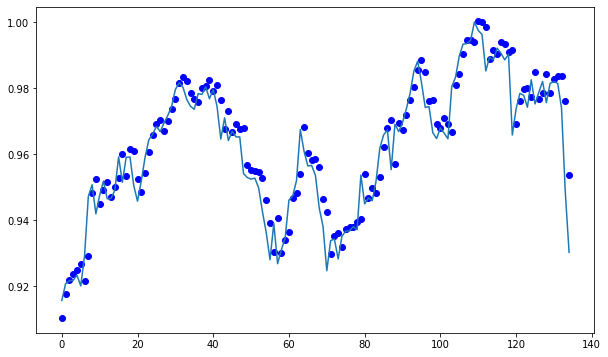

In [195]:
plt.figure(figsize=(10,6))
plt.plot(testpredictions, 'bo')
plt.plot(yvalarray)
plt.show()

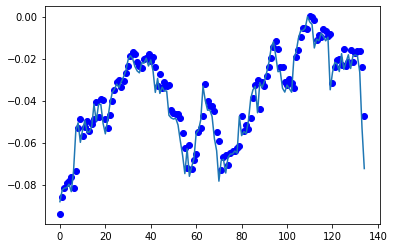

In [238]:
plt.plot(np.log(testpredictions), 'bo',)
plt.plot(np.log(yvalarray))
plt.show()

- The Mean Percentage Absolute Error, is probably the best comparison metric to use.
  - __mean_absolute_percentage_error__
  - easy to calculate by hand it's just |(targetVector-predictVector)|/targetVector
  - gives the % error each point was from what it meant to predict

- We can also check out the Root of the MSE. This will be like a point-wise standard deviation.
  - it is essentially a higher-penalty verison of the MAE.
  - Similarly it will be how far above/below our prediction is on average in raw units

# All of the Above was a test on the first model
## We can now do this for all four models, in a compact way

### we will find Root MSE, and MAPE for all four
### we should also plot the graphs

Above, we loaded the weights into the reloaded configurations

In [43]:
# load weights into new model
conf1.load_weights("MLP_competition_results_01_weights.h5")
conf2.load_weights("MLP_competition_results_02_weights.h5")
conf3.load_weights("MLP_competition_results_03_weights.h5")
conf4.load_weights("MLP_competition_results_04_weights.h5")

We will now recomplie each, and include the metrics we want

- Model 01: relu adam
- Model 02: relu sgd
- Model 03: sigmoid adam
- Model 04: sigmoid sgd

In [51]:
conf1.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "Dense", "config": {"name": "dense", "trainable": true, "batch_input_shape": [null, 9], "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null,

In [52]:
conf2.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Dense", "config": {"name": "dense_4", "trainable": true, "batch_input_shape": [null, 9], "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_5", "trainable": true, "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": n

In [53]:
conf3.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential_2", "layers": [{"class_name": "Dense", "config": {"name": "dense_8", "trainable": true, "batch_input_shape": [null, 9], "dtype": "float32", "units": 64, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_9", "trainable": true, "dtype": "float32", "units": 64, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constrai

In [54]:
conf4.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential_3", "layers": [{"class_name": "Dense", "config": {"name": "dense_12", "trainable": true, "batch_input_shape": [null, 9], "dtype": "float32", "units": 64, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_13", "trainable": true, "dtype": "float32", "units": 64, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constr

In [55]:
# example from above
# conftesta = get_model_config(modelconfigfilenames[0])
# conftesta.load_weights("MLP_competition_results_01_weights.h5")
# conftesta.compile(loss='MSE', optimizer='adam', metrics=['mse','accuracy',
#                                                         "mae","mape"])

conf1.compile(loss='MSE', optimizer='adam', metrics=['mape'])
conf2.compile(loss='MSE', optimizer='sgd', metrics=['mape'])
conf3.compile(loss='MSE', optimizer='adam', metrics=['mape'])
conf4.compile(loss='MSE', optimizer='sgd', metrics=['mape'])

These are the metrics we have.
- the Loss was MSE, so it's the same as the mean_squared_error metric

In [56]:
conf1.metrics_names

['loss', 'mean_absolute_percentage_error']

In [57]:
#score1,score2,score3,score4 = [confx.evaluate(X_validation, y_validation, verbose=0)
#                               for confx in (conf1,conf2,conf3,conf4)]
score1 = conf1.evaluate(X_validation, y_validation, verbose=0)
score2 = conf2.evaluate(X_validation, y_validation, verbose=0)
score3 = conf3.evaluate(X_validation, y_validation, verbose=0)
score4 = conf4.evaluate(X_validation, y_validation, verbose=0)

In [101]:
for scoring in (score1,score2,score3,score4): print(scoring)

[5.397956087512689e-05, 0.5550845]
[6.798704465230307e-05, 0.6101629]
[5.453747289720923e-05, 0.55372566]
[0.0012198651976952398, 3.4165385]


In [61]:
score3

[5.453747289720923e-05, 0.55372566]

This shows us that $~ReLU~+~Adam~$ is our clear winner.  
We also we how poorly $~Sigmoid~+~SGD~$ did in comparison.

__Now we graph__

In [62]:
y_targets_array = np.array(y_validation)

In [63]:
ready_models = (conf1,conf2,conf3,conf4)
testpred_list = tuple(mdl.predict(X_validation) for mdl in ready_models)

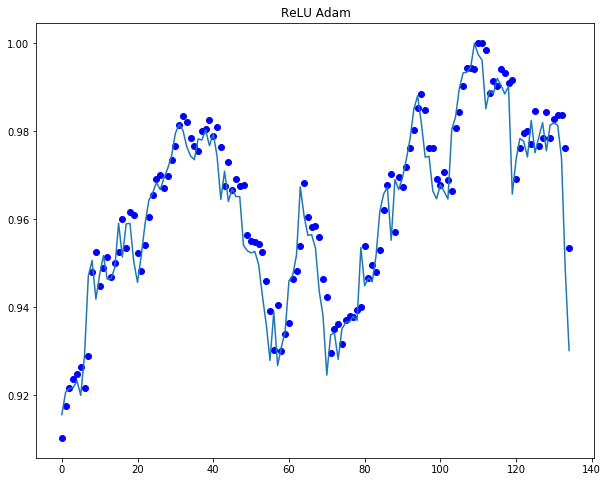

In [65]:
plt.figure(figsize=(10,8))
plt.plot(testpred_list[0], 'bo')
plt.plot(y_targets_array)
plt.title("ReLU Adam")
plt.show()

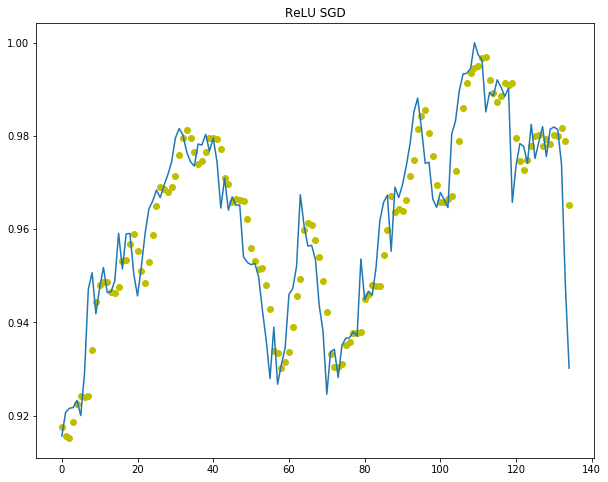

In [66]:
plt.figure(figsize=(10,8))
plt.plot(testpred_list[1], 'yo')
plt.plot(y_targets_array)
plt.title("ReLU SGD")
plt.show()

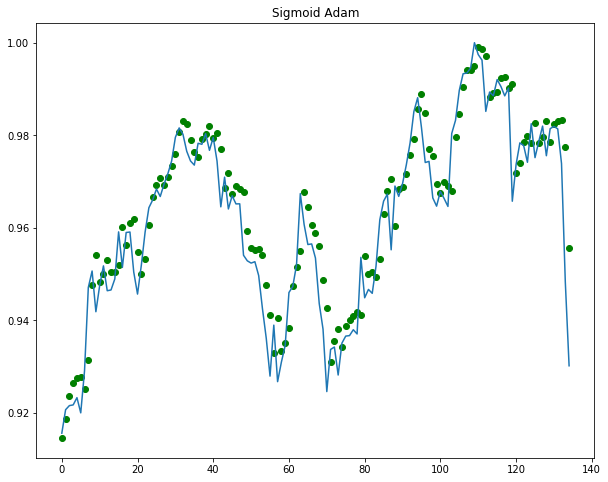

In [67]:
plt.figure(figsize=(10,8))
plt.plot(testpred_list[2], 'go')
plt.plot(y_targets_array)
plt.title("Sigmoid Adam")
plt.show()

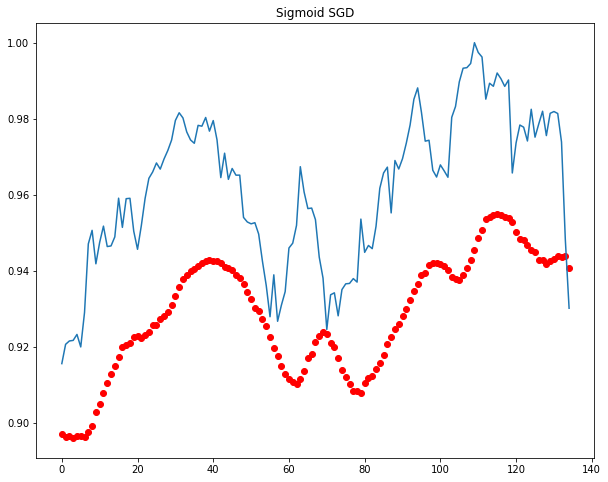

In [68]:
plt.figure(figsize=(10,8))
plt.plot(testpred_list[3], 'ro')
plt.plot(y_targets_array)
plt.title("Sigmoid SGD")
plt.show()

In [261]:
conf4.get_config()

{'layers': [{'class_name': 'Dense',
   'config': {'activation': 'sigmoid',
    'activity_regularizer': None,
    'batch_input_shape': (None, 9),
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros',
     'config': {'dtype': 'float32'}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'dtype': 'float32', 'seed': None}},
    'kernel_regularizer': None,
    'name': 'dense_12',
    'trainable': True,
    'units': 64,
    'use_bias': True}},
  {'class_name': 'Dense',
   'config': {'activation': 'sigmoid',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros',
     'config': {'dtype': 'float32'}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'dtype': 'float32', 'seed': None}},
    'kernel_regu

considering how bad model 4 was, I wonder if it's because of mini-batches and or shuffling.

Quick break to run those and see what happens.

In [93]:
 abs( (y_targets_array - testpred_list[2])/y_targets_array ).mean()

0.023560767014257324

In [87]:
pct3err = t3err/ y_targets_array

In [90]:
apct3err = abs(pct3err)

In [91]:
apct3err.mean()

0.023560767014257324

In [97]:
abs( (y_targets_array - testpred_list[0])/y_targets_array ).mean()

0.024072891912189885

In [98]:
abs( (y_targets_array - testpred_list[1])/y_targets_array ).mean()

0.023929198970263375

In [99]:
abs( (y_targets_array - testpred_list[3])/y_targets_array ).mean()

0.036363468132075256